Proposed Trading Strategy
-----
-  We place bids and asks at ALL times on levels 2, 3, 4, and 5. 
-  We place the orders above in an effort to gain valuable queue positions on our level 2-bid/ask orders.
-  When our queue position on our level 2 bid or ask orders reaches the top X% of the queue (X set to like 5% or 10%) we activate our strategy for the given direction.
-  Only when our strategy is active do we place any level 1 orders.
-  Now of course it is impossible to know the relative queue position in practice but it can be estimated fairly accurately, so here we will use the actual queue position (or add in some noise if desired).
-  Once our strategy is active, we look at our RNN predictions for next_midprice_move.
-  Given a positive (negative) price move signal, we place a limit buy (sell) order on the level 1 ask (bid). This order is immediately executed (as it is in a sense a market order).
-  We then wait until the midprice spread changes. If we predict the movement correctly, with high probability, we will make the spread once our level 2 order is filled. 
-  When we predict incorrectly, to avoid further loss, we close our position and in most cases lose double the spread.
-  We continue to repeat this process.


In [1]:
import pandas as pd
import numpy as np
import os
import math
import sys
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
sys.path.insert(0, os.path.join(os.getcwd(), 'code'))

import OrderBook as ob
import OrderUtil as ou
import TradingStrategySimulator as tss


In [2]:
#load in intc OrderBook data
book = ob.OrderBook(message_filename='INTC_message.csv', orderbook_filename='INTC_OrderBook.csv')

Perfectly Accurate Model
--------
Here we use an ideal 100% accurate model to see whether or not our strategy can be profitable

In [3]:
strat = {1: ([2, 3, 4, 5], [2, 3, 4, 5]),
         -1 : ([2, 3, 4, 5], [2, 3, 4, 5])}
midprice_df = book.get_midprice_data(numupdates=1, t_start=37000, t_end=40000, tick_size=100, next_move=True)
midprice_df.dropna(inplace=True)

backtester = tss.StrategyLossEstimation(book=book, midprice_df=midprice_df, mkt_order_on_move_predictions=True,
                                              strategy=strat,
                                              max_exposure_dict={1:0, -1:0}, relative_queue=0.25, 
                                              set_edge_queue=0.25, accuracy_rate=1, tick_size=100, queue_tol=0.5)
backtester.run_strategy_simulation()

1.0
Current time:        37000.012826949
Current pnl: 0.0
Current time:        37496.807132705
Current pnl: 0.0
market sell at 273000
limit bid executed at 272900
market sell at 272900
limit bid executed at 272800
market buy at 273300
limit ask executed at 273400
market buy at 273400
limit ask executed at 273500
market buy at 273500
limit ask executed at 273600
market buy at 273600
limit ask executed at 273700
market buy at 273700
limit ask executed at 273800
Current time:        38015.006603805
Current pnl: 700.0
market buy at 273800
limit ask executed at 273900
market buy at 273900
limit ask executed at 274000
market buy at 274000
limit ask executed at 274100
market buy at 274100
limit ask executed at 274200
market buy at 274200
limit ask executed at 274300
market buy at 274300
Current time:        38672.650771977
Current pnl: 1150.0
limit ask executed at 274400
market buy at 274400
limit ask executed at 274500
market buy at 274500
limit ask executed at 274600
market buy at 274600
li

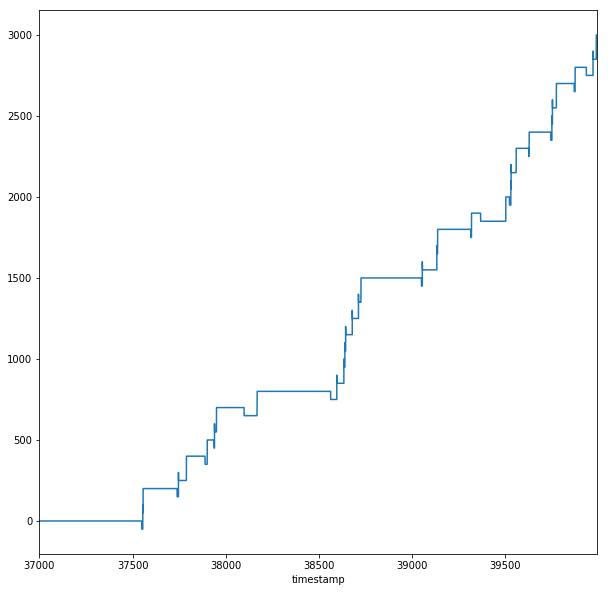

In [4]:
pnls = backtester._strategy_simulator.get_pnl_series()
pnls.cumsum().plot()
plt.show()

70% Accuracy
---------
Here we test a hypothetical model that has an average of 70% out of sample accuracy

In [5]:
strat = {1: ([2, 3, 4, 5], [2, 3, 4, 5]),
         -1 : ([2, 3, 4, 5], [2, 3, 4, 5])}
midprice_df = book.get_midprice_data(numupdates=1, t_start=37000, t_end=40000, tick_size=100, next_move=True)
midprice_df.dropna(inplace=True)
backtester = tss.StrategyLossEstimation(book=book, midprice_df=midprice_df, mkt_order_on_move_predictions=True,
                                        strategy=strat,
                                        max_exposure_dict={1:0, -1:0}, relative_queue=0.25, 
                                        set_edge_queue=0.25, accuracy_rate=0.7, tick_size=100, queue_tol=0.5)
backtester.run_strategy_simulation()

0.7011394292205027
Current time:        37000.012826949
Current pnl: 0.0
market sell at 273000
Current time:        37496.807132705
Current pnl: -200.0
market sell at 273000
limit bid executed at 272900
market sell at 272900
limit bid executed at 272800
market buy at 273300
limit ask executed at 273400
market buy at 273400
limit ask executed at 273500
market buy at 273500
market buy at 273500
limit ask executed at 273600
market buy at 273600
limit ask executed at 273700
market buy at 273700
limit ask executed at 273800
Current time:        38015.006603805
Current pnl: 300.0
market buy at 273800
limit ask executed at 273900
market buy at 273900
market sell at 273400
market buy at 273900
limit ask executed at 274000
market buy at 274000
limit ask executed at 274100
market buy at 274100
limit ask executed at 274200
market buy at 274200
limit ask executed at 274300
market buy at 274300
Current time:        38672.650771977
Current pnl: 350.0
limit ask executed at 274400
market buy at 274400

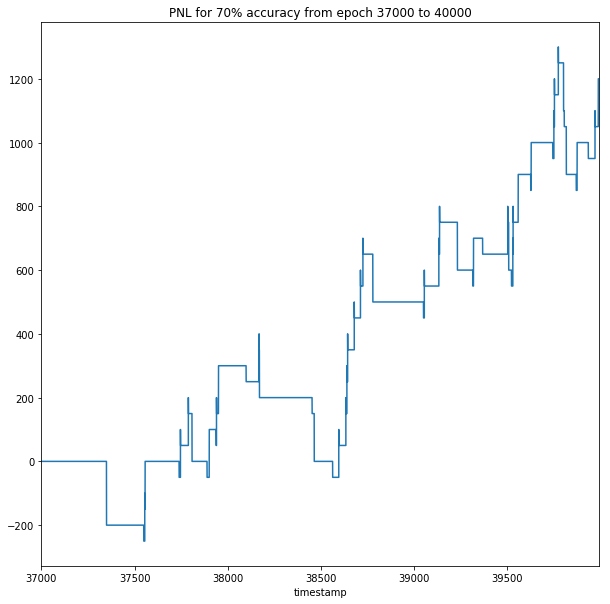

In [6]:
pnls = backtester._strategy_simulator.get_pnl_series()
pnls.cumsum().plot()
plt.title('PNL for 70% accuracy from epoch 37000 to 40000')
plt.show()